# Learn actively, and listen carefully to small-text

In this tutorial you will learn how 

In [ ]:
%pip install datasets small-text scikit-learn

In [1]:
import datasets

trec = datasets.load_dataset('trec')

Using custom data configuration default
Reusing dataset trec (/home/david/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Extract the text features
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(trec["train"]["text"])

## Set up Active Learner

In [3]:
import numpy as np
from small_text.base import LABEL_UNLABELED
from small_text.data import SklearnDataset


# Create a dataset for small-text
dataset = SklearnDataset(text_features, np.array([LABEL_UNLABELED]*len(trec["train"])))

In [4]:
dataset_test = SklearnDataset(
    vectorizer.transform(trec["test"]["text"]),
    np.array(trec["test"]["label-coarse"]),
)

In [5]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool-based sampling 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

## Set up Rubrix dataset

In [6]:
import rubrix as rb

DATASET_NAME = "trec_with_active_learning"


# Define labeling schema
labels = trec["train"].features["label-coarse"].names
settings = rb.TextClassificationSettings(label_schema=labels)

# Apply seetings to a new or already existing dataset
rb.configure_dataset(name=DATASET_NAME, settings=settings)

In [7]:
from small_text.initialization import random_initialization
import numpy as np
# Fix seed for reproducibility 
np.random.seed(42)

NUM_SAMPLES = 10


# Get a few initial datapoints
initial_indices = random_initialization(dataset, NUM_SAMPLES)

# Log initial datapoints for annotation
records = [
    rb.TextClassificationRecord(text=trec["train"]["text"][idx], id=idx)
    for idx in initial_indices
]
rb.log(records, DATASET_NAME)

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/datasets/rubrix/trec_with_active_learning


BulkResponse(dataset='trec_with_active_learning', processed=10, failed=0)

In [8]:
from rubrix.listeners import listener
from sklearn.metrics import accuracy_score

LABEL2INT = trec["train"].features["label-coarse"].str2int
ACCURACIES = []


@listener(
    dataset=DATASET_NAME,
    query="status:Validated",
    execution_interval_in_seconds=2,
)
def active_learning_loop(records, ctx):
    # Get indices of the newly annotated records
    indices = np.array([rec.id for rec in records])
    new_indices = np.setdiff1d(indices, active_learner.indices_labeled)   
    
    # We still have to do some annotating
    if len(new_indices) < NUM_SAMPLES:
        return
        
    # Update active learner
    # initial update
    if len(active_learner.indices_labeled) == 0:
        y = np.array([LABEL2INT(rec.annotation) for rec in records])
        active_learner.initialize_data(new_indices, y)
    # update with the prior queried indices
    else:
        y = np.array([LABEL2INT(rec.annotation) for rec in records if rec.id in new_indices])
        active_learner.update(y)
        
    # Query active learner
    queried_indices = active_learner.query(num_samples=NUM_SAMPLES)
    new_records = [
        rb.TextClassificationRecord(text=trec["train"]["text"][idx], id=idx)
        for idx in queried_indices
    ]
    rb.log(new_records, DATASET_NAME)    
    
    # Optional, evaluate current classifier on the test set
    dataset_test = SklearnDataset(
        vectorizer.transform(trec["test"]["text"]), 
        np.array(trec["test"]["label-coarse"])
    )
    accuracy = accuracy_score(
        dataset_test.y, 
        active_learner.classifier.predict(dataset_test),
    )
    ACCURACIES.append(accuracy)

In [9]:
active_learning_loop.start()

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/datasets/rubrix/trec_with_active_learning


In [10]:
active_learning_loop.stop()

## Simulation

In [14]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner

clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)
query_strategy = BreakingTies()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

In [15]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)
y = np.array(trec["train"]["label-coarse"])
initial_indices = random_initialization(dataset)
active_learner.initialize_data(initial_indices, y[initial_indices])

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
accuracies = []

for _ in range(200):
    acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
    accuracies.append(acc)
    
    idx = active_learner.query(num_samples=10)
    active_learner.update(y[idx])
    
acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
accuracies.append(acc)

<AxesSubplot:>

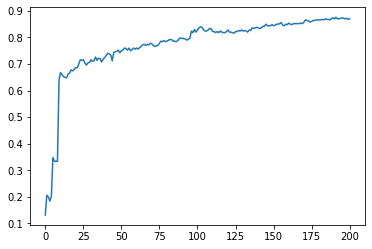

In [42]:
pd.Series(accuracies).plot()